In [1]:
import numpy as np
import pylab as plt
import requests
import io
import pymc as pm

from scipy import stats, linalg

## Recreating Fantasy Math

[Fantasy Math](https://www.nathanbraun.com/fantasymath/) model used to help set fantasy football line-ups. Models the player outputs as a function of their [ECR](https://www.fantasypros.com/nfl/rankings/ppr-wr-cheatsheets.php).

In [2]:
class Player:
    def __init__(self, alpha, beta, player_name=None, team=None, position=None):
        """
        """
        self.name = player_name
        self.team = team
        self.position = position
        self.alpha = alpha
        self.beta = beta

    def _populate_statistics(self):
        """
        Take information from a table and load it into a dictionary
        """
        self.statistics = {}
        
    def _get_weekly_ecr(self):
        """
        """
        pass
    
    def _cls(self):
        """
        """
        pass

Procedure for generating correlated samples

1. Define distributions associated with each random variable (player score)
    1. This comes from historical data associated with the player ECR
2. Define correlations between random variables
    1. Again historical data
3. Sample from correlated distributions
    1. asdf

In [3]:
alpha_x = 4.0 # Shape parameter for X
beta_x = 1.0 # Rate parameter for X

alpha_y = 3.0
beta_y = 0.5 

# Degree of correlation
correlation = 0.5

# Define the covariance matrix
corr = np.array([
    [1, correlation], [correlation, 1]
])


nsamples = 50000
samples_correlated = np.random.multivariate_normal(np.zeros(2), corr, size=nsamples)

In [4]:
samples_x = stats.gamma.ppf(
    stats.norm.cdf(samples_correlated[:, 0]),
    alpha_x,
    scale=beta_x ** -1,
)

samples_y = stats.gamma.ppf(
    stats.norm.cdf(samples_correlated[:, 1]),
    alpha_y,
    scale=beta_y ** -1,
)

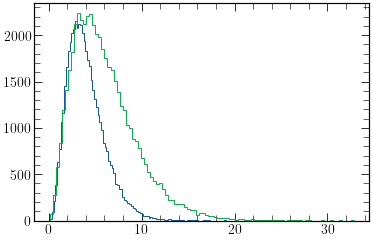

In [5]:
plt.figure()
plt.hist(np.random.gamma(alpha_x, 1 / beta_x, size=nsamples), bins=100, histtype='step')
plt.hist(np.random.gamma(alpha_y, 1 / beta_y, size=nsamples), bins=100, histtype='step')
plt.show()

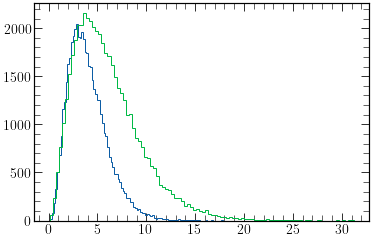

In [6]:
plt.figure()
plt.hist(samples_x, bins=100, histtype='step')
plt.hist(samples_y, bins=100, histtype='step')
plt.show()

## Teams

In [7]:
def generate_samples(dist_params, correlation, nsamples=1000):
    """
    """
    assert len(dist_params) == correlation.shape[0], "A"

    # asdf
    samples = np.random.multivariate_normal(
        np.zeros(correlation.shape[0]), correlation, nsamples
    )

    players = []
    for player_ind, (alpha, beta) in enumerate(dist_params):
        player_samples = stats.gamma.ppf(
            stats.norm.cdf(samples[:, player_ind]), alpha, scale=beta ** -1,
        )
        players.append(player_samples)

    return np.array(players)

def fit_gamma_distribution(statistics, method='MLE', loc=0.0):
    """
    """
    if method == "MLE":
        shape, _, scale = stats.gamma.fit(statistics, floc=loc)
        
    elif method == 'Bayes':
        shape, scale = None, None 
    
    else:
        raise ValueError(f"Method, {method}, is currently unsupoorted")
    return 

In [8]:
# Generate mock rosters and correlations between players
nplayers = 10
dist_params1 = list(zip(np.full(nplayers, 10), np.linspace(0.5, 0.5, nplayers)))
dist_params2 = list(zip(np.full(nplayers, 10), np.linspace(0.1, 0.2, nplayers)))

nsamples = 10000
used_off_diagonal_terms = True

if used_off_diagonal_terms:
    correlation = np.random.uniform(0, 0.25, size=(10, 10))
    correlation[np.diag_indices_from(correlation)] = 1
    correlation = (correlation + correlation.T) / 2
else:
    correlation = np.diag(np.ones(nplayers))

team1 = generate_samples(dist_params1, correlation, nsamples=nsamples)
team2 = generate_samples(dist_params2, correlation, nsamples=nsamples)

In [9]:
params = [stats.gamma.fit(team1[i], floc=0.0) for i in range(team1.shape[0])]

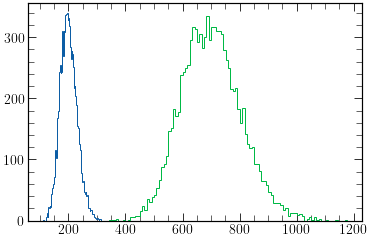

In [10]:
plt.figure()
plt.hist(team1.sum(0), bins=100, histtype='step')
plt.hist(team2.sum(0), bins=100, histtype='step')
plt.show()

In [11]:
from scipy import special

def win_probability(team1, team2):
    """
    Gives the probability of team 1 scoring a higher than team 2 assuming team 1 and team 2
    are Gaussian distributed
    """
    mu1 = np.mean(team1)
    mu2 = np.mean(team2)
    mu = mu1 - mu2
    
    var1 = np.var(team1)
    var2 = np.var(team2)
    var = var1 + var2
    
    return special.erfc(-mu / np.sqrt(2 * var)) / 2

In [12]:
X = np.sum(team1, axis=0)
Y = np.sum(team2, axis=0)

### Bayesian Modeling

Another approach we can take to modeling the distribution of player outcomes, is by performing an MCMC fit of a Gamma distribution to the data. This approach allows us to account of uncertainties in our estimate of the Gamma distribution and incorporate those incertainties into the sampling. This approach is far slower, but in theory, produces samples which better match the true points distribution.

Posteriors look roughly Gaussian. Perhaps the best thing to do would be to fit the MCMC to the true distributions. After computing the mean and covariance of the posteriors, we can generate $\alpha$ and $\beta$ samples from a multivariate Gaussian distribution. We can then use these $\alpha$ and $\beta$ values to sample from Gamma distributions to simulate.

In [14]:
# Sample data (replace with your own dataset)
x = np.linspace(0, 20, 500)
#P = stats.norm.pdf(x, 2, 1) + stats.norm.pdf(x, 4., 1.7)
#P /= P.sum()
#data = np.random.choice(x, p=P, size=500)
data = stats.gamma.rvs(5, scale=2, size=500)

#P = (stats.gamma.pdf(x, 5, scale=2) + stats.gamma.pdf(x, 12, scale=1))
#P /= P.sum()
#data = np.random.choice(x, p=P, size=500)

# Define a PyMC3 model
with pm.Model() as model:
    # Define the parameters of the gamma distribution
    #shape = pm.Exponential("shape", lam=1.0)
    #rate = pm.Exponential("rate", lam=1.0)
    shape = pm.Uniform("shape", lower=3, upper=7)
    rate = pm.Uniform("rate", lower=0.1, upper=1)
    
    # Define the likelihood using the gamma distribution
    likelihood = pm.Gamma("likelihood", alpha=shape, beta=rate, observed=data)
    
    # Perform Bayesian inference
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [shape, rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 49 seconds.


In [15]:
mu_shape, _ = trace.posterior.shape.mean(), trace.posterior.shape.std()
mu_rate, _ = trace.posterior.rate.mean(), trace.posterior.rate.std()

shape, rate = np.array(trace.posterior.shape), np.array(trace.posterior.rate)
C = np.cov(np.column_stack([shape.ravel(), rate.ravel()]).T)
SHAPE, RATE = np.random.multivariate_normal(np.array([mu_shape, mu_rate]), C, size=1000).T

In [16]:
std = np.std([stats.gamma.pdf(x, SHAPE[i], scale=RATE[i] ** -1) for i in range(1000)], axis=0)
mean = np.mean([stats.gamma.pdf(x, SHAPE[i], scale=RATE[i] ** -1) for i in range(1000)], axis=0)

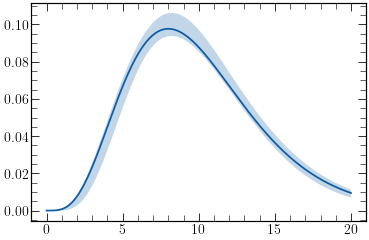

In [19]:
plt.fill_between(x, mean - 1.96 * std, mean + 1.96 * std, alpha=0.25)
plt.plot(x, stats.gamma.pdf(x, 5, scale=2))
#plt.plot(x, 25 * P)

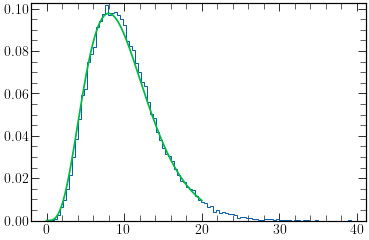

In [20]:
plt.hist(np.random.gamma(shape.ravel(), rate.ravel() ** -1), bins=100, histtype='step', density=True)
plt.plot(x, stats.gamma.pdf(x, 5, scale=2))

## Correlations

In [21]:
import pandas as pd

In [22]:
def process_rbs(table, n_rbs=2):
    """
    """
    player = [" ".join(list(name)[:-1]) for name in table['Name'].str.split(' ')]
    teams = [name[-1] for name in table['Name'].str.split(' ')]
    table['Name'] = player
    table['Team'] = teams

    rb_table = []
    for team in table['Team'].unique():
        subtable = table[table['Team'] == team].sort_values('FantPt', ascending=False)
        rb_table.append(subtable.iloc[:n_rbs])
        
    return pd.concat(rb_table)

def process_qbs(table, n_qbs=1):
    """
    """
    player = [" ".join(list(name)[:-1]) for name in table['Name'].str.split(' ')]
    teams = [name[-1] for name in table['Name'].str.split(' ')]
    table['Name'] = player
    table['Team'] = teams
    
    qb_table = []
    for team in table['Team'].unique():
        subtable = table[table['Team'] == team].sort_values('FantPt', ascending=False)
        qb_table.append(subtable.iloc[:n_qbs])
        
    return pd.concat(qb_table)

In [23]:
def power(seasons=np.arange(2015, 2023), positions=['qb', 'wr', 'rb', 'te'], n_players=[1, 3, 2, 1]):
    rows = []
    
    weeks = np.arange(1, 17)
    for year in seasons:
        for week in weeks:
            pos_tables = []
            for n_player, position in zip(n_players, positions):
                url = f"https://www.footballguys.com/playerhistoricalstats?pos={position}&yr={year}&startwk={week}&stopwk={week}&profile=p"
                tables = pd.read_html(
                    io.StringIO(requests.get(url).text)
                )
                table = tables[0]
                pos_tables.append(process_rbs(table, n_rbs=n_player))

            for team in pos_tables[0]["Team"].unique():
                group = []
                for pos_table in pos_tables:
                    group += list(pos_table[pos_table["Team"] == team]["FantPt"])

                rows.append(group)
            
    return rows

In [24]:
%%time
rows = power()

CPU times: user 42.8 s, sys: 988 ms, total: 43.8 s
Wall time: 4min 48s


In [25]:
rows = np.array([row for row in rows if len(row) == 7])

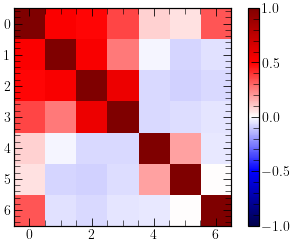

In [26]:
plt.figure()
corr = np.corrcoef(np.array(rows).T)
plt.imshow(corr, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

In [29]:
rows.shape

(3793, 7)

In [34]:
rho, _ = stats.spearmanr(rows[:])

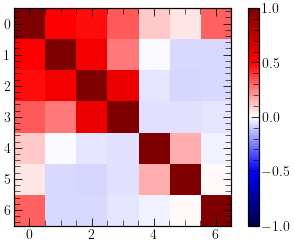

In [35]:
plt.figure()
plt.imshow(rho, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

## All the Pieces

In [120]:
%%time
n_sims = 10000 # number of simulations

# Sample shape and rate parameters from covariance matrix (do this for every player)
SHAPE, RATE = np.random.multivariate_normal(np.array([mu_shape, mu_rate]), C, size=n_sims).T

# Generate random correlation matrix
corr = np.random.uniform(0, 0.1, size=(10, 10))
corr = (corr + corr.T) / 2
corr[np.diag_indices_from(corr)] = 1

# Samples from correlation matrix
samples_correlated = np.random.multivariate_normal(np.zeros(corr.shape[0]), corr, size=n_sims)

CPU times: user 7.3 ms, sys: 1.87 ms, total: 9.16 ms
Wall time: 6.83 ms


In [121]:
%%time
all_samples = []
for player_ind in range(corr.shape[0]):
    samples_x = stats.gamma.ppf(
        stats.norm.cdf(samples_correlated[:, player_ind]),
        SHAPE,
        scale=RATE ** -1,
    )
    all_samples.append(samples_x)
    
all_samples = np.array(all_samples)

CPU times: user 95 ms, sys: 2.74 ms, total: 97.8 ms
Wall time: 96.6 ms


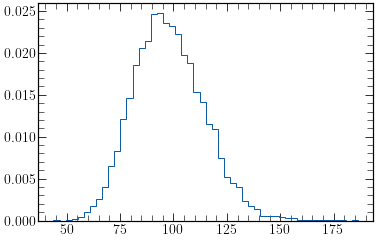

In [122]:
plt.figure()
plt.hist(np.sum(all_samples, axis=0), histtype='step', density=True, bins=50)
plt.show()

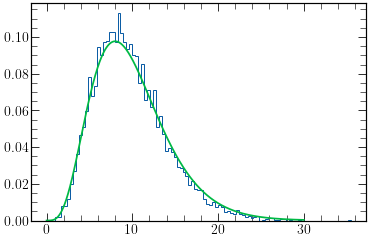

In [127]:
x = np.linspace(0, 30, 1000)
plt.hist(samples_x, histtype='step', bins=100, density=True)
plt.plot(x, stats.gamma.pdf(x, 5, scale=2))

In [60]:
positions=['qb', 'wr', 'rb', 'te']
n_players=[1, 3, 2, 1]

urls = [
    f"https://www.footballguys.com/playerhistoricalstats?pos={position}&yr={year}&startwk={week}&stopwk={week}&profile=p"
    for year in np.arange(2015, 2023) for week in np.arange(1, 17) for n_player, position in zip(n_players, positions)
]

async def fetch_html(session, url):
    try:
        async with session.get(url) as response:
            response.raise_for_status()
            return await response.text()
    except aiohttp.ClientError as e:
        print(f"Error fetching {url}: {e}")
        return None

async def main():
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_html(session, url) for url in urls]
        html_contents = await asyncio.gather(*tasks)

    tables = []
    # Parse the HTML content using pd.read_html
    for html_content in html_contents:
        if html_content is not None:
            try:
                tables.append(pd.read_html(html_content))
            except pd.errors.EmptyDataError:
                print("No data found in HTML.")
    
    return tables